In [1]:
from IPython.display import display
from IPython.display import Image
import os
from utils import * # Code shared across more than one notebook

# gVirtualXRay CT acquisition vs chest phantom CT data

**Main contributors:** J. Pointon, J. Tugwell-Allsup and F. P. Vidal

**Purpose:** In this notebook, we aim to demonstrate that:

1. gVirtualXRay is able to generate analytic simulations on GPU comparable to projections obtained with the Radon transform of a real CT scan,
2. gVirtualXRay is able to generate analytic simulations on GPU comparable to digitally reconstructed radiographs (DRRs) of a real CT scan computed with [Plastimatch](https://plastimatch.org/).

**Material and Methods:** For this experiment, we attempt to recreate a real projections of the [Lungman chest phantom](https://www.kyotokagaku.com/en/products_data/ph-1_01/) with gVirtualXRay. 

In [ ]:
fname = "./plots/lungman_model.png"
if os.path.exists(fname):
    display(Image(fname))

1. The CT of a chest phantom has been generated from a real scanner ahead of time. 
2. Structures in the reference CT have been segmented and labelled. 
3. The resultant surfaces from the segmentations form a virtual lungman model. 
4. We use gVirtualXRay to simulate X-ray projection on this model and 
5. compare the result with Digitally Reconstructed Radiographs (DRRs) of the original CT scan.

In [2]:
Image("doc/lungman-validation-DRR-flow.png", width=800)

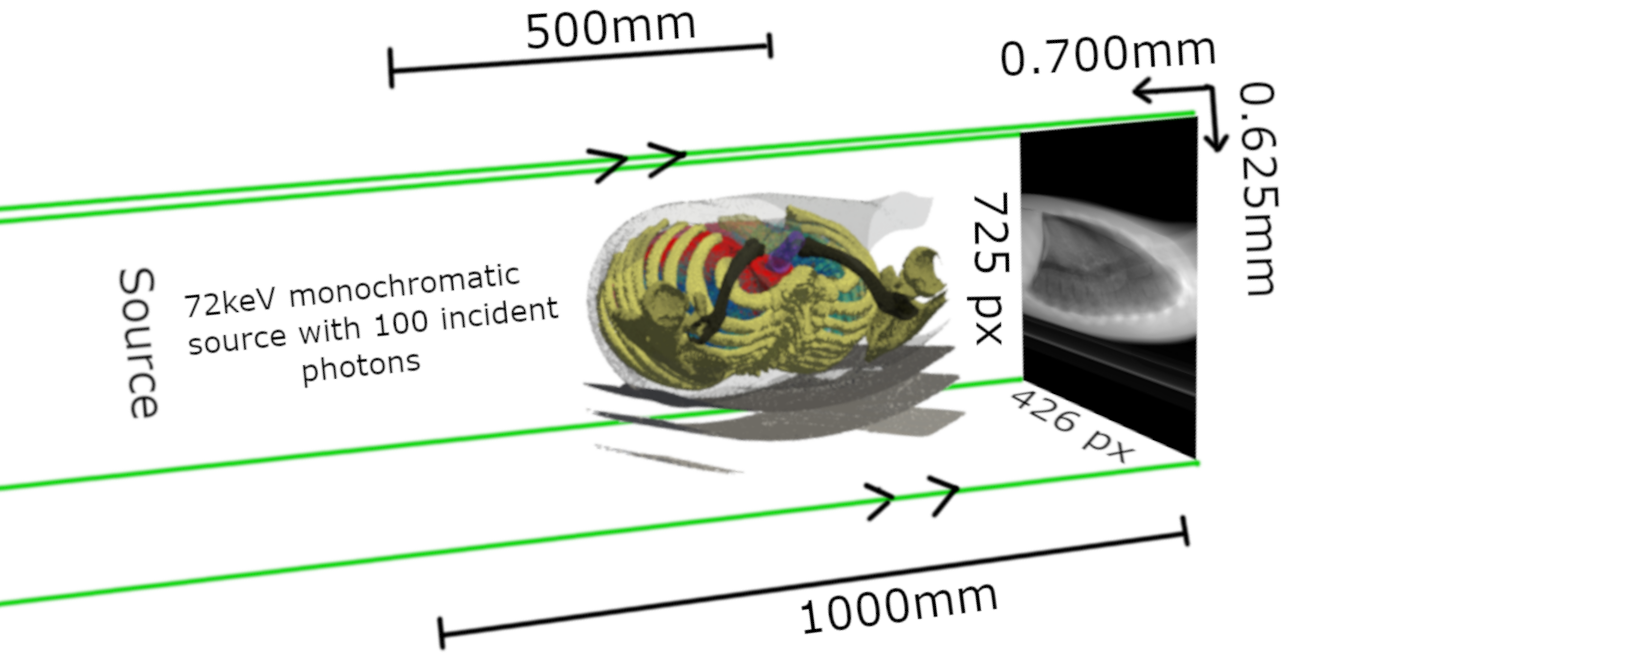

In [4]:
Image("../doc/gvxr-lungman-environment.png", width=800)

# Results

**Diagonal plot comparison**\
These two plots are sampled from the diagonal pixels of slice 150 from both the ground truth CT and simulated CT of the chest phantom.\
<span style="color:green">Green</span>: Ground truth CT plot\
<span style="color:red">Red</span>: Simulated CT plot\
This experiment proves the most significant changes in attenuation are accurately simulated. The simulated CT appears less noisy presumably because our experiment does not account for the natural deviation of image quality that comes with real equipment.

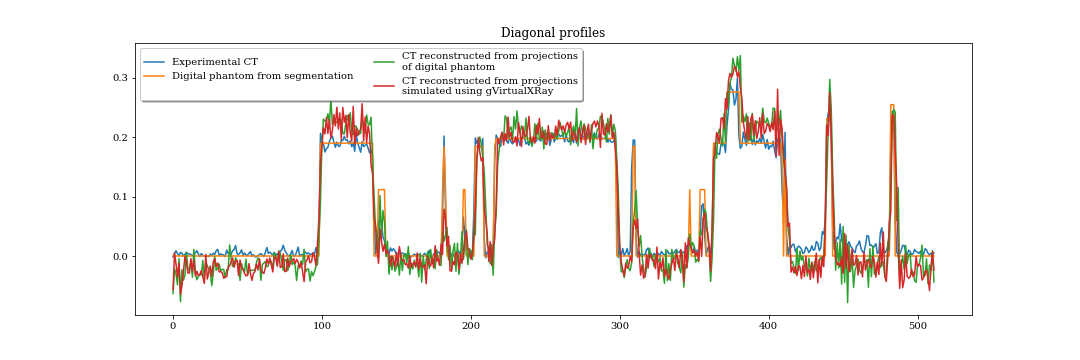

In [5]:
fname = "plots/lungman-profiles-CT-mu.png"
if os.path.exists(fname):
    display(Image(fname))

**Quantitative comparisons**\
From qauntative measures we achieved: a ZNCC score of 0.977 (97.7% similarity), a MAPE/MAPD 0.293 and a SSIM score of 0.911. For reference, a good ZNCC and SSIM score is 1 and a good MAPE score is 0.

The calculations were performed on the following platform:

In [6]:
printSystemInfo()

OS:
	Linux 5.3.18-150300.59.49-default
	x86_64

CPU:
 	AMD Ryzen 7 3800XT 8-Core Processor

RAM:
	63 GB
GPU:
	Name: GeForce RTX 2080 Ti
	Drivers: 455.45.01
	Video memory: 11 GB


# Import packages

In [3]:
%matplotlib inline

import SimpleITK as sitk
import pandas as pd
import numpy as np
import numpy.ma as ma # Masking
from utils import *
from convertRaw import *
import gvxrPython3 as gvxr
import json2gvxr

import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'serif'#,
        #'weight' : 'bold',
         # 'size'   : 22
       }
matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)

from tifffile import imread, imwrite # Load/Write TIFF file

from sitk2vtk import *
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim
import skimage

#import scipy
import os
import math
import zipfile
import datetime

import imageio

import k3d
import random
import base64
from stl import mesh
from time import sleep

SimpleGVXR 1.0.1 (2022-03-11T15:11:24) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2022-03-11T15:11:23) [Compiler: GNU g++] on Linux


In [4]:
SAVE_DATA = False
GENERATE_NEW_DATA_ALWAYS = True
DO_K3D_PLOT = True

In [7]:
ray_energy = 72
DO_ARTEFACT_FILTERING_ON_GPU = True
DO_ARTEFACT_FILTERING_ON_CPU = False

# Configure gVirtualXRay environment
**Create an OpenGL context and window.**

In [8]:
json2gvxr.initGVXR("notebook-8.json", "OPENGL");

Create an OpenGL context: 512x512


0



Thu Mar 24 17:00:32 2022 ---- Create window gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Thu Mar 24 17:00:33 2022 ---- Use OpenGL 4.5.0 0 512 512


**Create a parallel photon beam.**

In [13]:
json2gvxr.initSourceGeometry();
gvxr.setMonoChromatic(ray_energy, "keV", 100);
gvxr.useParallelBeam();

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


**Create a detector array.**

In [14]:
json2gvxr.initDetector("notebook-11.json");

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, 1]
	Detector number of pixels: [725, 426]
	Pixel spacing: [0.625, 0.7, 'mm']
INIT RENDER


In [15]:
nb_pixels = gvxr.getDetectorNumberOfPixels()
detector_size = gvxr.getDetectorSize("mm")
pixel_width = detector_size[0] / nb_pixels[0]
pixel_height = detector_size[1] / nb_pixels[1]

# Load the CT scan

In [10]:
# Read the reference CT
sitk_reader = sitk.ImageFileReader();
sitk_reader.SetImageIO("MetaImageIO");
sitk_reader.SetFileName("lungman_data/lungman.mha")
raw_ground_truth = sitk_reader.Execute()
real_CT_in_HU = np.array(sitk.GetArrayFromImage(raw_ground_truth));

#
# Blur using CurvatureFlowImageFilter
#
# blurFilter = sitk.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# sitk_ground_truth_CT_recons_in_HU = blurFilter.Execute(raw_ground_truth)
# ground_truth_CT_recons_in_HU = np.array(sitk.GetArrayFromImage(sitk_ground_truth_CT_recons_in_HU));

# Make sure each volume has floating point precision
real_CT_in_HU = real_CT_in_HU.astype(np.single);

# Drop the first and last slices
# ground_truth_CT_recons_in_HU = ground_truth_CT_recons_in_HU[1:ground_truth_CT_recons_in_HU.shape[0] - 1]

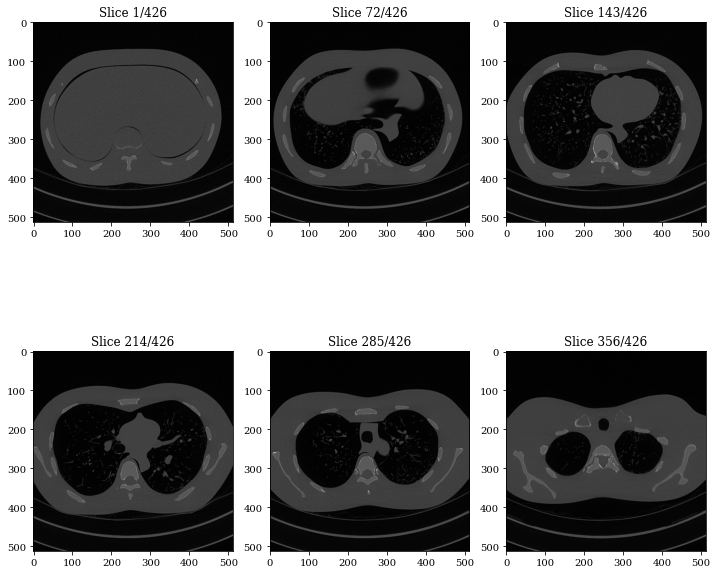

In [12]:
ncols = 3
nrows = 2

step = int(real_CT_in_HU.shape[0] / (ncols * nrows))
slices = range(0, int(real_CT_in_HU.shape[0]), step)

fig = plt.figure(figsize= (10,10))

ct_min_val = real_CT_in_HU.min()
ct_max_val = real_CT_in_HU.max()

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(real_CT_in_HU.shape[0]))
        ax.imshow(real_CT_in_HU[slice_id], cmap='gray', vmin=ct_min_val, vmax=ct_max_val)
        
plt.tight_layout()

plt.savefig('plots/lungman-real_CT_in_HU.pdf')
plt.savefig('plots/lungman-real_CT_in_HU.png')

In [13]:
def ShouldGenerateNew(*fnames):
    
    if (GENERATE_NEW_DATA_ALWAYS):
        return True
    
    for fname in fnames:
        if (not os.path.exists(fname)):
            return True
        
    return False

# Convert ground truth from HU to &mu;

In [14]:
fname = "gVirtualXRay_output_data/lungman-real_CT_in_mu.mha"

if ShouldGenerateNew(fname):

    #real_CT_in_mu = np.array(gvxr.convertHU2mu(real_CT_in_HU, ray_energy, "keV"))
    mu_air  =gvxr.getMuFromHU(-1000.0, 72, "keV");
    mu_water  =gvxr.getMuFromHU(0.0, 72, "keV");
    real_CT_in_HU = real_CT_in_HU.astype(np.double);
    real_CT_in_mu = ((real_CT_in_HU / 1000.0 ) * (mu_water - mu_air)) + mu_water;
  
   
    if SAVE_DATA:
      
        sitk_real_CT_in_mu = sitk.GetImageFromArray(real_CT_in_mu)
        sitk_real_CT_in_mu.SetSpacing([pixel_width, pixel_width, pixel_height])

        sitk_real_CT_in_mu.SetOrigin((-pixel_width * real_CT_in_mu.shape[2] / 2.0,
                              -pixel_width * real_CT_in_mu.shape[1] / 2.0,
                              -pixel_height * real_CT_in_mu.shape[0] / 2.0))
    
        sitk.WriteImage(sitk_real_CT_in_mu, fname, useCompression=True)

else:
    sitk_real_CT_in_mu = sitk.ReadImage(fname)
    real_CT_in_mu = sitk.GetArrayFromImage(sitk_real_CT_in_mu)

# Extract data for this experiment
The labelled volumes are provided compressed in a zip file. Use this procedure to extract the surfaces and masks needed for this notebook.

In [15]:
# Uncompress the labels
if (False == os.path.isfile("./lungman_data/segmentation-uncompressed/labels.mha")):
    with zipfile.ZipFile(  "./lungman_data/segmentation-compressed.zip", 'r') as myzip:
        myzip.extractall(  "./lungman_data/segmentation-uncompressed")

# Read the records for isovalue, average HU
mapHandle = open("./lungman_data/segmentation-uncompressed/map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

# Read labels
label_rel_path = "./lungman_data/segmentation-uncompressed/labels.mha";
phantom = sitk.ReadImage(label_rel_path)
phantom_array = sitk.GetArrayFromImage(phantom)

In [ ]:
# rd = vtk.vtkMetaImageReader();
# rd.SetFileName(label_rel_path);
# rd.Update()
# vtkLabels = rd.GetOutput();

# Create threshold filter
# threshold = vtk.vtkImageThreshold();
# threshold.SetInputData(vtkLabels);
# threshold.SetReplaceOut(0);
# threshold.ReplaceOutOn()
# threshold.ReplaceInOff();

fname_HU = "gVirtualXRay_output_data/lungman-ground_truth2-CT-in_HU.mha"
fname_mu = "gVirtualXRay_output_data/lungman-ground_truth2-CT-in_mu.mha"

ref_data = {}

if ShouldGenerateNew(fname_HU, fname_mu):
    digital_phatom_in_HU = np.zeros(phantom_array.shape, dtype=np.int16) - 1000
    digital_phatom_in_mu = np.zeros(phantom_array.shape, dtype=np.single)
else:
    sitk_digital_phatom_in_HU = sitk.ReadImage(fname_HU)
    digital_phatom_in_HU = sitk.GetArrayFromImage(sitk_digital_phatom_in_HU)

    sitk_digital_phatom_in_mu = sitk.ReadImage(fname_mu)
    digital_phatom_in_mu = sitk.GetArrayFromImage(sitk_digital_phatom_in_mu)    
    
for i in range(0, len(split_lines)):
    
    tuple_parts = split_lines[i].split('\t');
    
    structure_name = tuple_parts[2][0:-4]
    structure_isovalue = int(tuple_parts[0])

    print("Process", structure_name)
    
    # See if the surface already exists
    stl_rel_path = "./lungman_data/meshes/" + tuple_parts[2][0:-4] + ".stl";
    # if (True == os.path.isfile(stl_rel_path)): continue;
    
    # Threshold to get label
#     threshold.ThresholdBetween(structure_isovalue, structure_isovalue);
#     threshold.Update();
#     vtkIm = threshold.GetOutput();
    
#     # Extract surface and save
#     vtkSurface = extractSurface(vtkIm, structure_isovalue);
#     writeSTL(vtkSurface, stl_rel_path);
#     vtkSurface = None;
#     vtkIm = None;    

    # Threshold the phantom
    binary_mask = (phantom == structure_isovalue)
    
    # Pad the image
    filt = sitk.ConstantPadImageFilter()
    filt.SetConstant (0)
    filt.SetPadLowerBound ([1, 1, 1])
    filt.SetPadUpperBound ([1, 1, 1])
    binary_image = filt.Execute(binary_mask)               

    # Create a VTK image
    binary_array = sitk.GetArrayFromImage(binary_image)
    vtkimg = sitk2vtk(binary_image, centre=True)

    # binary_array = sitk.GetArrayFromImage(binary_image)
    min_val = binary_array.min()
    max_val = binary_array.max()

    threshold = min_val + 0.5 * (max_val - min_val)

    vtkmesh = extractSurface(vtkimg, threshold)
    del vtkimg

    writeSTL(vtkmesh, stl_rel_path)
    del vtkmesh
    
    
    # Get HU/mu

    if ShouldGenerateNew(fname_HU, fname_mu):

        kernel_radius = 2;

        # Sheets are too slim to be eroded so much
        if (structure_name.find("sheet") != -1):
            kernel_radius = 1;

        # Erode the mask
        erode = sitk.BinaryErodeImageFilter();
        erode.SetKernelRadius(kernel_radius);
        erode.SetForegroundValue(1);
        sitk_eroded_mask = erode.Execute(binary_mask);
        del erode

        eroded_mask = np.array(sitk.GetArrayFromImage(sitk_eroded_mask));
        del sitk_eroded_mask

        # Apply mask to simulated CT
        erored_test = (eroded_mask == 1)
        
        test = phantom_array == structure_isovalue
        avg_HU = np.mean(real_CT_in_HU[erored_test])
        avg_mu = np.mean(real_CT_in_mu[erored_test])

        # print("\t\t\"Material\": [\"HU\",", avg_HU, "]")
                
        ref_data[structure_name] = [avg_HU, avg_mu]
        digital_phatom_in_HU[test] = round(avg_HU)
        digital_phatom_in_mu[test] = avg_mu

Process bronchioles
Process bronchus
Process trachea
Process diaphram
Process skin
Process heart


In [ ]:
if ShouldGenerateNew(fname_HU, fname_mu):
    
    if SAVE_DATA:
        sitk_digital_phatom_in_HU = sitk.GetImageFromArray(digital_phatom_in_HU)

        sitk_digital_phatom_in_HU.SetOrigin((-pixel_width * digital_phatom_in_HU.shape[2] / 2.0,
                      -pixel_width * digital_phatom_in_HU.shape[1] / 2.0,
                      -pixel_height * digital_phatom_in_HU.shape[0] / 2.0))

        sitk_digital_phatom_in_HU.SetSpacing([pixel_width, pixel_width, pixel_height])
        sitk.WriteImage(sitk_digital_phatom_in_HU, fname_HU, useCompression=True)



        sitk_digital_phatom_in_mu = sitk.GetImageFromArray(digital_phatom_in_mu)

        sitk_digital_phatom_in_mu.SetOrigin((-pixel_width * digital_phatom_in_mu.shape[2] / 2.0,
                     -pixel_width * digital_phatom_in_mu.shape[1] / 2.0,
                      -pixel_height * digital_phatom_in_mu.shape[0] / 2.0))

        sitk_digital_phatom_in_mu.SetSpacing([pixel_width, pixel_width, pixel_height])
        sitk.WriteImage(sitk_digital_phatom_in_mu, fname_mu, useCompression=True)

# Create a phantom model from each mesh and its material

In [ ]:
json2gvxr.initSamples();

In [ ]:
number_of_triangles = 0

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    number_of_triangles_in_mesh = gvxr.getNumberOfPrimitives(label)
    number_of_triangles += number_of_triangles_in_mesh
    
print("There are", f"{number_of_triangles:,}", "triangles in total")

## Visualise the virtual patient

In [35]:
if (DO_K3D_PLOT):
    plot = k3d.plot()
    plot.background_color = 0xffffff

    for sample in json2gvxr.params["Samples"]:

        label = sample["Label"]

        fname = sample["Path"]

         #r, g, b, a = gvxr.getAmbientColour(label)
         #R = math.floor(255*r)
         #G = math.floor(255*g)
         #B = math.floor(255*b)
         #A = math.floor(255*a)
        R = sample["Colour"][0];
        G = sample["Colour"][1];
        B = sample["Colour"][2];
        o = sample["Colour"][3];

        k3d_color = 0;
        k3d_color |= (R & 255) << 16;
        k3d_color |= (G & 255) << 8;
        k3d_color |= (B & 255);

        mesh_from_stl_file = mesh.Mesh.from_file(fname)
        opacity = o;
         #if label == "Skin":
         #    opacity = 0.2
         #else:
         #    opacity = 1
        geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                               range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                               color=k3d_color, 
                               wireframe=False, 
                               flat_shading=False,
                               name=fname,
                               opacity=opacity)

        plot += geometry   

    plot.display()
    plot.camera = [458.4242199518181, -394.5268107574361, 59.58430140683608, 93.26420522817403, -15.742963565665017, -45.88423611599179, -0.08892603121323975, 0.11140808541436767, 0.9897880578573034]

In [36]:
fname = 'plots/lungman_model.png'
if DO_K3D_PLOT and ShouldGenerateNew(fname):

        
    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    sleep(5)
    plot.fetch_screenshot();
    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)
        fp.flush();
        fp.close();

**Visualise a single projection**

0 0 500 500
0 0 512 512


(-0.5, 511.5, 511.5, -0.5)

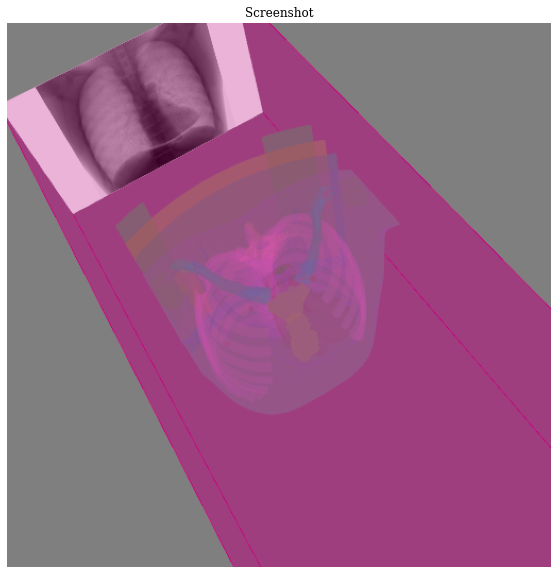

In [37]:
gvxr.computeXRayImage()
gvxr.displayScene()

# Give each mesh an alpha value
alpha = 0.2;
for i in range(gvxr.getNumberOfChildren('root')):
    label = gvxr.getChildLabel('root', i);
    pRGBA = gvxr.getAmbientColour(label);
    gvxr.setColour(label, pRGBA[0], pRGBA[1], pRGBA[2],alpha);

gvxr.useLighing(False)
gvxr.useWireframe(False)
gvxr.setZoom(1000)
gvxr.setSceneRotationMatrix([ 0.8535534,  0.5000000, -0.1464466,0,
  -0.5000000,  0.7071068, -0.5000000,0,
  -0.1464466,  0.5000000,  0.8535534,0,
                            0.0, 0.0, 0.0, 1.0])
gvxr.displayScene()


screenshot = gvxr.takeScreenshot()

plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

# Do projections

Every epoch, the scene is rotated by a step such that the number of chosen projections is reached over 180 degrees and an image is produced on the detector array. At the end a set of X-Ray images is obtained in likeness to the raw data produced by a medical scanner except sliced in a different direction.

In [38]:
%%capture
runtimes = []
fname = "gVirtualXRay_output_data/lungman_flat.mha"
if ShouldGenerateNew(fname):


    gvxr.disableArtefactFiltering()

    if DO_ARTEFACT_FILTERING_ON_GPU:
        gvxr.enableArtefactFilteringOnGPU()
    elif DO_ARTEFACT_FILTERING_ON_CPU:
        gvxr.enableArtefactFilteringOnCPU()

    raw_projections = [];
    angles = [];
    runtimes = []

    # Create a GIF file
    writer = None
    fname_gif = "plots/lungman_acquisition.gif"

    if not os.path.exists(fname_gif):
        writer = imageio.get_writer(fname_gif, mode='I')

    # Save the transformation matrix
    transformation_matrix_backup = gvxr.getSceneTransformationMatrix()

    rotation_axis = json2gvxr.params["Detector"]["UpVector"]

    for angle_id in range(0, number_of_projections):

        # Add the rotation angle, starting from 0
        angles.append(angle_id * angular_step)

        # Compute an X-ray image
        # xray_image = np.array(gvxr.computeXRayImage());
        start_time = datetime.datetime.now()

        xray_image = gvxr.computeXRayImage()

        # if xray_image.shape != [208, 1062]:
        #     xray_image = resize(xray_image, [208, 1062])

        # xray_image = np.array(gvxr.computeXRayImage());

        end_time = datetime.datetime.now()
        delta_time = end_time - start_time
        runtimes.append(delta_time.total_seconds() * 1000)

        # Add to the set of projections
        raw_projections.append(xray_image)

        # Update the rendering
        gvxr.displayScene();

        # Take a screenshot
        if writer is not None:
            if not angle_id % 30:
                screenshot = gvxr.takeScreenshot()

                plt.figure(figsize= (10,10))
                plt.title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
                plt.imshow(screenshot)
                plt.axis('off')

                plt.tight_layout()

                plt.savefig('temp.png')            
                plt.close()


                image = imageio.imread("temp.png")
                writer.append_data(image)

        # Rotate the sample
        gvxr.rotateScene(angular_step, rotation_axis[0], rotation_axis[1], rotation_axis[2])

    # We're done with the writer
    if writer is not None:
        writer.close()
        os.remove("temp.png")

    # Convert to numpy arrays
    raw_projections = np.array(raw_projections)

    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(transformation_matrix_backup)

    # Update the rendering
    gvxr.displayScene();

In [39]:
if (len(runtimes) > 0):
    runtime_avg = round(np.mean(runtimes))
    runtime_std = round(np.std(runtimes))
else:
    runtime_avg = -1;
    runtime_std = 0;

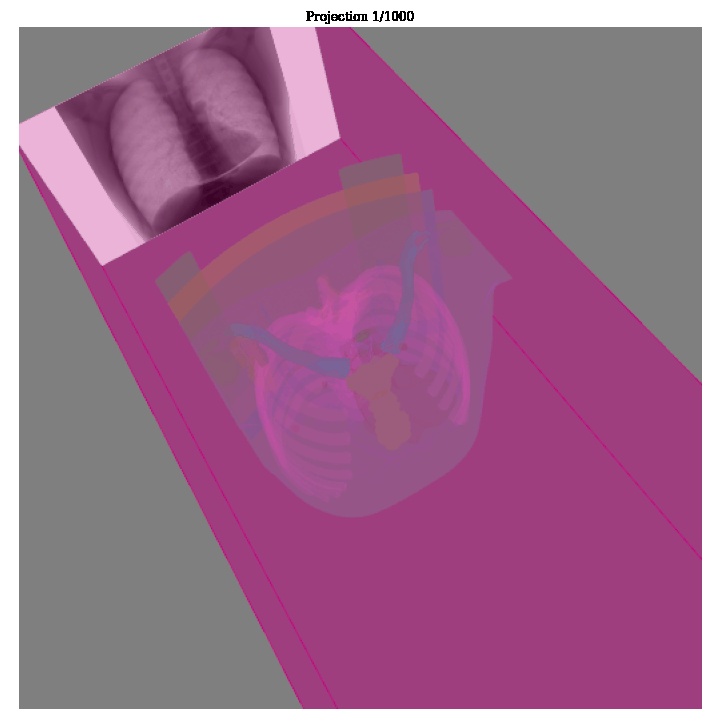

In [40]:
with open('./plots/lungman_acquisition.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=500))

# Correct flat-field

Taking advantage of the detector response when there is no sample can help improve the quality of images when a sample is present. To elaborate, any variance between pixels when the detector is dark (X-Ray beam off) or full (X-Ray beam on) with no density will affect the quality of images with a sample. Factoring for this systematic error is called flat-field correction. \
N: corrected image\
P: projection\
D: dark field\
F: full field\
$N = \frac{P - D}{F - D}$\
In this routine the projection data is flat-fielded.



In [41]:
if ShouldGenerateNew(fname):
    
    corrected_projections = flatFieldCorrection(raw_projections)
    corrected_projections = np.array(corrected_projections).astype(np.single)

    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(corrected_projections)
        sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
        sitk.WriteImage(sitk_image, fname, useCompression=True)
        del raw_projections # Not needed anymore
    
else:
    temp = sitk.ReadImage(fname)
    corrected_projections = sitk.GetArrayFromImage(temp)

# Negative log normalisation

In [42]:
fname = "gVirtualXRay_output_data/lungman_minus_log_projs.mha"

if ShouldGenerateNew(fname):

    minus_log_projs = minusLog(corrected_projections)

    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(minus_log_projs)
        sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
        sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    temp = sitk.ReadImage(fname)
    minus_log_projs = sitk.GetArrayFromImage(temp)
    
del corrected_projections # Not needed anymore

Display the images

In [43]:
proj_min = minus_log_projs.min()
proj_max = minus_log_projs.max()

Draw the projection

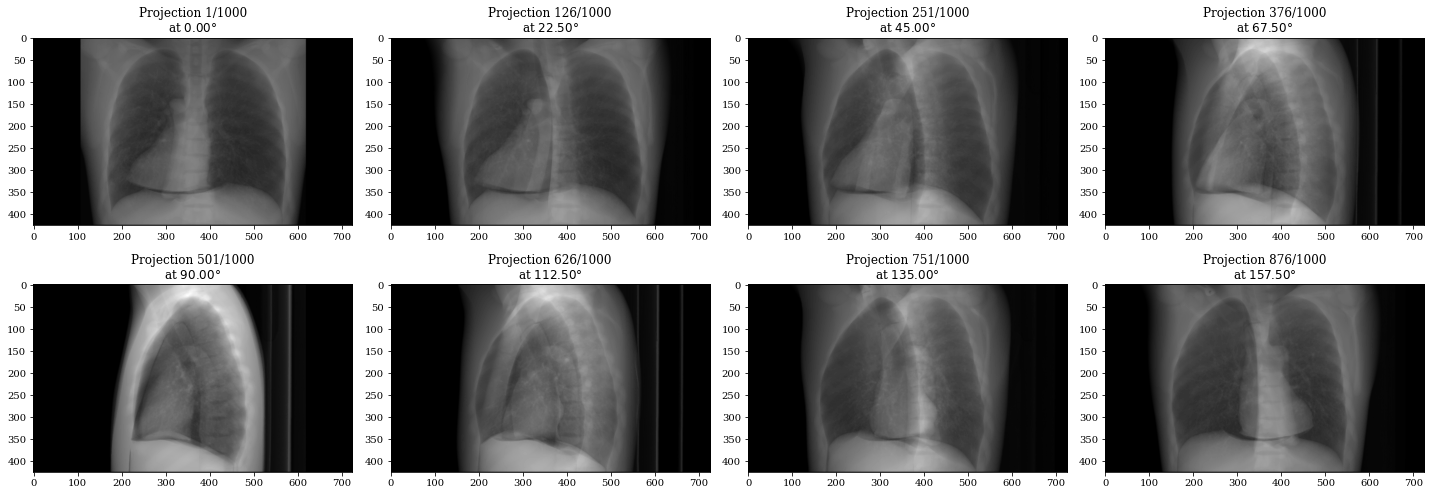

In [44]:
ncols = 4
nrows = 2

step = int(minus_log_projs.shape[0] / (ncols * nrows))
slices = range(0, int(minus_log_projs.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Projection " + str(slice_id + 1) + "/" + str(minus_log_projs.shape[0]) + "\nat $" + "{:.2f}".format(theta_deg[slice_id]) + "\degree$")
        ax.imshow(skimage.transform.rotate(minus_log_projs[slice_id], 180),
                  cmap='gray',
                  vmin=proj_min,
                  vmax=proj_max)

plt.tight_layout()


plt.savefig('plots/lungmand-simulated-projs.pdf')
plt.savefig('plots/lungmand-simulated-projs.png')

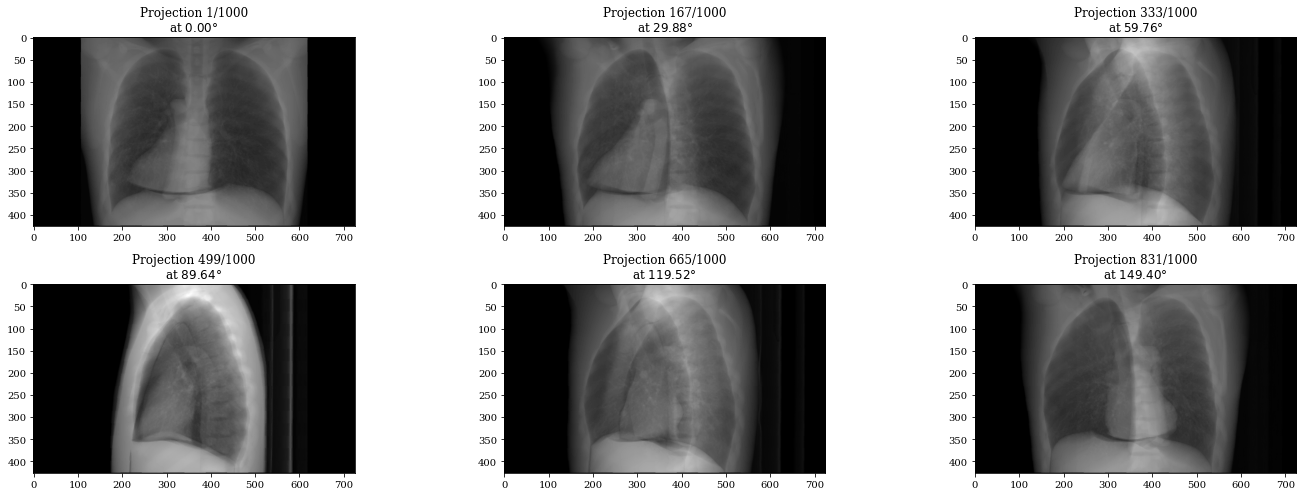

In [45]:
ncols = 3
nrows = 2

step = int(digital_phantom_proj.shape[0] / (ncols * nrows))
slices = range(0, int(digital_phantom_proj.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Projection " + str(slice_id + 1) + "/" + str(digital_phantom_proj.shape[0]) + "\nat $" + "{:.2f}".format(theta_deg[slice_id]) + "\degree$")
        
        # ref_slice = ground_truth_CT_recons_in_HU[ground_truth_CT_recons_in_HU.shape[0] // 2]
        # test_slice = CT_volume_in_HU[CT_volume_in_HU.shape[0] // 2]

        ref_slice = digital_phantom_proj[slice_id]
        test_slice = minus_log_projs[slice_id]

        comp_equalized = compare_images(ref_slice, test_slice, method='checkerboard', n_tiles=(15,15))

        ax.imshow(skimage.transform.rotate(comp_equalized, 180),
                  cmap='gray',
                  vmin=ground_truth_sino_min,
                  vmax=ground_truth_sino_max)

plt.tight_layout()

plt.savefig('plots/lungman-checkboard-compare-projs.pdf')
plt.savefig('plots/lungman-checkboard-compare-projs.png')

Save the sinograms

In [46]:
fname = "gVirtualXRay_output_data/lungman_sinograms.mha"
    
if ShouldGenerateNew(fname):
    
    sino_shape = [
        minus_log_projs.shape[1],
        minus_log_projs.shape[0],
        minus_log_projs.shape[2]
    ]
    
    sinograms = np.zeros(sino_shape).astype(np.single)
    
    for angle_id in range(minus_log_projs.shape[0]):
        for slice_id in range(minus_log_projs.shape[1]):
            sinograms[slice_id, angle_id] = minus_log_projs[angle_id, slice_id]

    # Drop the first and last slices
    # sinograms = sinograms[1:sinograms.shape[0] - 1]
    
    # Save
    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(sinograms)
        sitk_image.SetSpacing([pixel_width, angular_step, pixel_height])
        sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    temp = sitk.ReadImage(fname)
    sinograms = sitk.GetArrayFromImage(temp)

Plot some sinograms

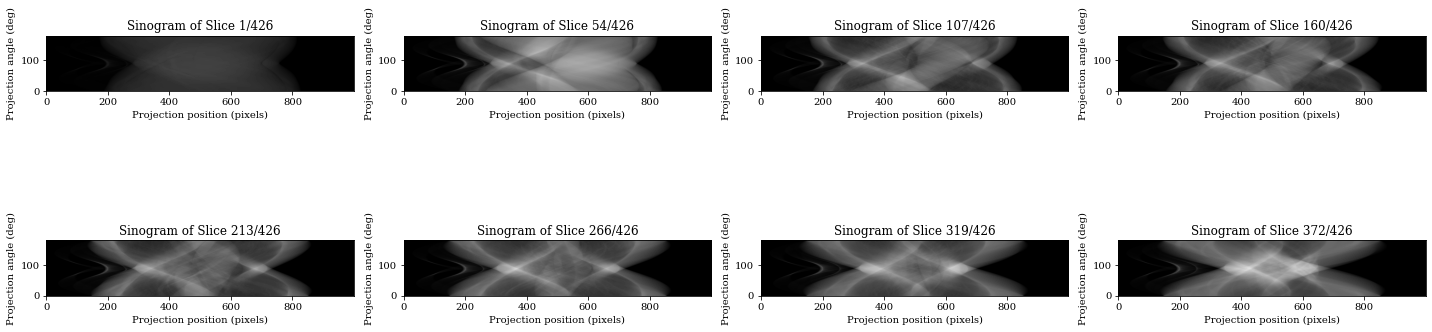

In [47]:
ncols = 4
nrows = 2

step = int(sinograms.shape[0] / (ncols * nrows))
slices = range(0, int(sinograms.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Sinogram of Slice " + str(slice_id + 1) + "/" + str(sinograms.shape[0]))
        ax.imshow(sinograms[slice_id],
                  extent=[0, sinograms.shape[1] - 1, theta_deg[0], theta_deg[-1]],
                  cmap='gray',
                  vmin=proj_min, vmax=proj_max)
        ax.set_xlabel("Projection position (pixels)")
        ax.set_ylabel("Projection angle (deg)")
        
plt.tight_layout()


plt.savefig('plots/lungman-simulated-sino.pdf')
plt.savefig('plots/lungman-simulated-sino.png')

## Optimise Plastimatch centre
**Use objective function to find optimimum centre. i.e. register the DRR onto the radiograph**

In [48]:
from pymoo.util.misc import stack
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from threading import Thread
from sklearn.metrics import mean_absolute_percentage_error

def normImage(image_to_normalise):
    image_to_normalise -= np.mean(image_to_normalise);
    stddev = np.std(image_to_normalise);
    if (stddev == 0): stddev = 0.0001;
    image_to_normalise/= stddev;
    
def measure(truth, predict):
    N = 1.0;
    dims = np.shape(truth);
    for i in range(0, len(dims)):
        N *= dims[i];
    if (N == 0): return -1, -1, -1, -1, -1;
    
    zncc_denom = N * np.std(truth) * np.std(predict);
    if (zncc_denom == 0): zncc_denom = 0.00001;
        
    sub = truth - predict;
    
    mae_score = np.sum(np.abs(sub)) / N;
    zncc_score =  np.sum( (truth  - np.mean(truth)) *(predict - np.mean(predict))) / zncc_denom;
    rmse_score =  np.sqrt(np.sum(np.power(sub, 2)) / N)
    mape_score = mean_absolute_percentage_error(truth, predict);
    ssim_score = ssim(truth, predict);
    return mae_score, zncc_score, rmse_score, mape_score, ssim_score

def objective(cx, cy):
        DRR = doLungmanDRRNumpy(g_NRM[0], g_NRM[1], g_NRM[2], 
                           cx, cy, 
                            "DRR_", 
                            g_XRay.shape[1], g_XRay.shape[0]
                            
                           );
        DRR = DRR.astype(np.single);
        normImage(DRR);
        mae, zncc, rmse, mape, ssim = measure(g_XRay, DRR);
        zncc = 1.0 - ((zncc + 1.0) /2.0);
        ssim = 1.0 - ssim;
        row = []
    
        row.append(mae);
        row.append(zncc);
        row.append(rmse);
        row.append(mape);
        row.append(ssim);
        return row;

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=5,
                         n_constr=0,
                         xl=np.array([0, -g_XRay.shape[0]]),
                         xu=np.array([g_XRay.shape[1],0])
                         )
    
  
      
    
    def _evaluate(self, X, out, *args, **kwargs):
            objs = []
            for tuple in X:
                objs.append(objective(tuple[0], tuple[1]));

            out["F"] = objs;
        
        
import time
from pymoo.factory import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

termination = get_termination("n_gen", 100)


algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=False
)
#normImage(xray_AP);
#normImage(xray_RL);

from pymoo.optimize import minimize

**Generate optimise result if not done so already**

In [49]:
import pymoo.core.result;

fname_nsga_rl_X = "gVirtualXRay_output_data/R-L-res-nsga2-X.dat";
fname_nsga_rl_F = "gVirtualXRay_output_data/R-L-res-nsga2-F.dat";
fname_nsga_ap_X = "gVirtualXRay_output_data/A-P-res-nsga2-X.dat";
fname_nsga_ap_F = "gVirtualXRay_output_data/A-P-res-nsga2-F.dat";

r_l_res_exists = not ShouldGenerateNew(fname_nsga_rl_X, fname_nsga_rl_F);
    
a_p_res_exists = not ShouldGenerateNew(fname_nsga_ap_X, fname_nsga_ap_F);

res_ap = pymoo.core.result.Result();
res_rl = pymoo.core.result.Result();

minus_log_proj_rl = np.copy(np.flip(minus_log_projs[(number_of_projections) // 2]));
minus_log_proj_ap = np.copy(np.flip(minus_log_projs[len(minus_log_projs) - 1]));
normImage(minus_log_proj_rl);
normImage(minus_log_proj_ap);
s="Time taken {t} seconds.";

if (r_l_res_exists):
    print("Getting R-L result from file");
    res_rl.X = np.loadtxt(fname_nsga_rl_X)
    res_rl.F = np.loadtxt(fname_nsga_rl_F)
else:
    print("Optimising R-L");
    g_NRM = [1, 0, 0]
    g_XRay = minus_log_proj_rl;
  
    problem = MyProblem();

    t_start = time.time();
    res_rl = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

    t_end = time.time();
    print(s.format(t=(t_end - t_start)));
    
    np.savetxt(fname_nsga_rl_X, res_rl.X)
    np.savetxt(fname_nsga_rl_F, res_rl.F)

if (a_p_res_exists):
    print("Getting A-P result from file");
    res_ap.X = np.loadtxt(fname_nsga_ap_X)
    res_ap.F = np.loadtxt(fname_nsga_ap_F)
else:
    print("Optimising A-P");
    g_NRM = [0, -1, 0]
    g_XRay = minus_log_proj_ap;
    
    problem = MyProblem();

    t_start = time.time();
    res_ap = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

    t_end = time.time();
    print(s.format(t=(t_end - t_start)));
    
    np.savetxt(fname_nsga_ap_X, res_ap.X)
    np.savetxt(fname_nsga_ap_F, res_ap.F)

Optimising R-L
I/O time: 0.000683 sec
Total time: 0.033437 secs
I/O time: 0.000741 sec
Total time: 0.00749803 secs
I/O time: 0.000722 sec
Total time: 0.0135281 secs
I/O time: 0.000731 sec
Total time: 0.0157592 secs
I/O time: 0.000736 sec
Total time: 0.0300829 secs
I/O time: 0.000748 sec
Total time: 0.0401418 secs
I/O time: 0.000735 sec
Total time: 0.028605 secs
I/O time: 0.000727 sec
Total time: 0.0140102 secs
I/O time: 0.000749 sec
Total time: 0.033289 secs
I/O time: 0.000717 sec
Total time: 0.0140729 secs
I/O time: 0.001289 sec
Total time: 0.0493209 secs
I/O time: 0.000740 sec
Total time: 0.0298328 secs
I/O time: 0.000751 sec
Total time: 0.0466609 secs
I/O time: 0.000744 sec
Total time: 0.0103879 secs
I/O time: 0.000736 sec
Total time: 0.0226231 secs
I/O time: 0.000743 sec
Total time: 0.0174839 secs
I/O time: 0.000732 sec
Total time: 0.0426629 secs
I/O time: 0.000778 sec
Total time: 0.0333679 secs
I/O time: 0.000747 sec
Total time: 0.059473 secs
I/O time: 0.000649 sec
Total time: 0.0

Optimum c for right to left 577.46 , -57.38
Optimum c for anterior to posterior 349.52 , -58.79
I/O time: 0.000681 sec
Total time: 0.0487099 secs
I/O time: 0.000879 sec
Total time: 0.0470209 secs
I/O time: 0.000742 sec
Total time: 0.0469699 secs
I/O time: 0.000727 sec
Total time: 0.0638871 secs
I/O time: 0.000799 sec
Total time: 0.0501721 secs
I/O time: 0.000739 sec
Total time: 0.0430801 secs
I/O time: 0.001366 sec
Total time: 0.052299 secs
I/O time: 0.000789 sec
Total time: 0.0500779 secs
I/O time: 0.000755 sec
Total time: 0.0468521 secs
I/O time: 0.000757 sec
Total time: 0.0440941 secs
I/O time: 0.000756 sec
Total time: 0.0532629 secs
I/O time: 0.000707 sec
Total time: 0.0493929 secs
I/O time: 0.000792 sec
Total time: 0.047411 secs
I/O time: 0.000834 sec
Total time: 0.0449529 secs
I/O time: 0.000755 sec
Total time: 0.047132 secs
I/O time: 0.000827 sec
Total time: 0.0452318 secs
I/O time: 0.000835 sec
Total time: 0.051054 secs
I/O time: 0.000797 sec
Total time: 0.0447092 secs
I/O time

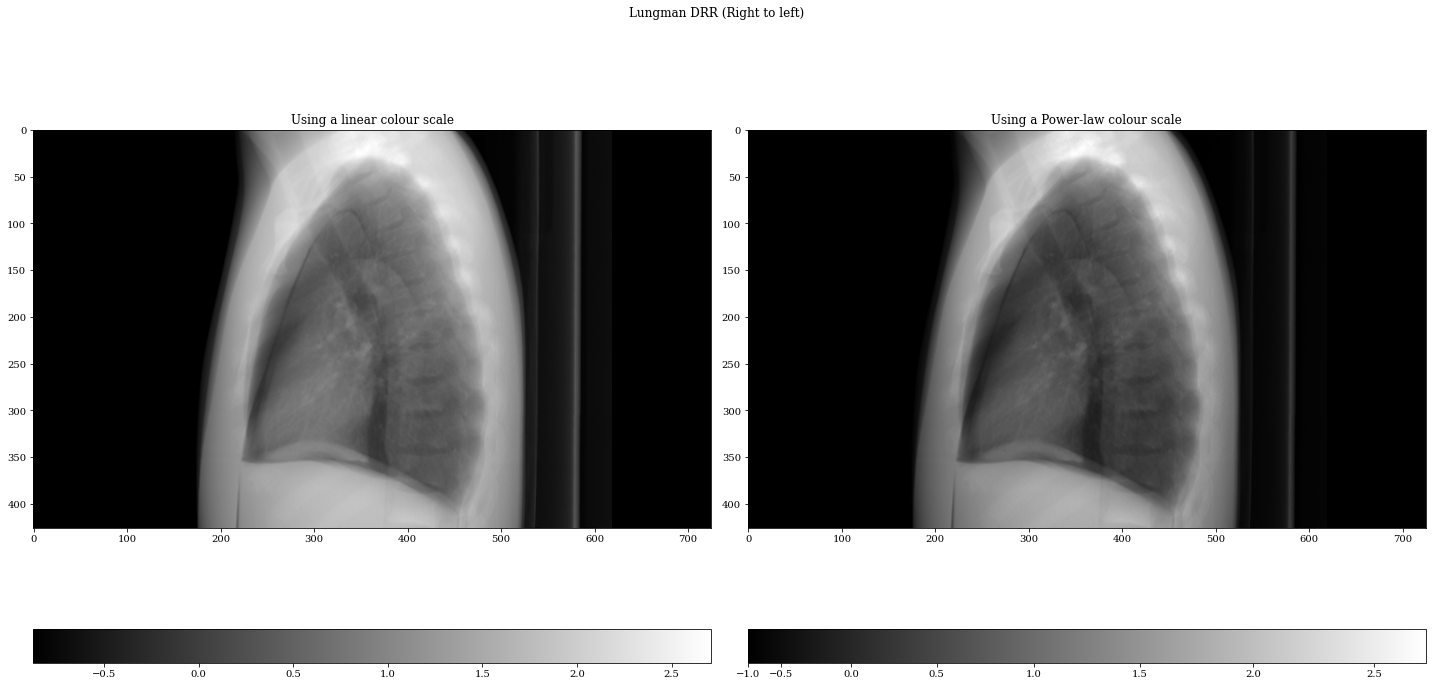

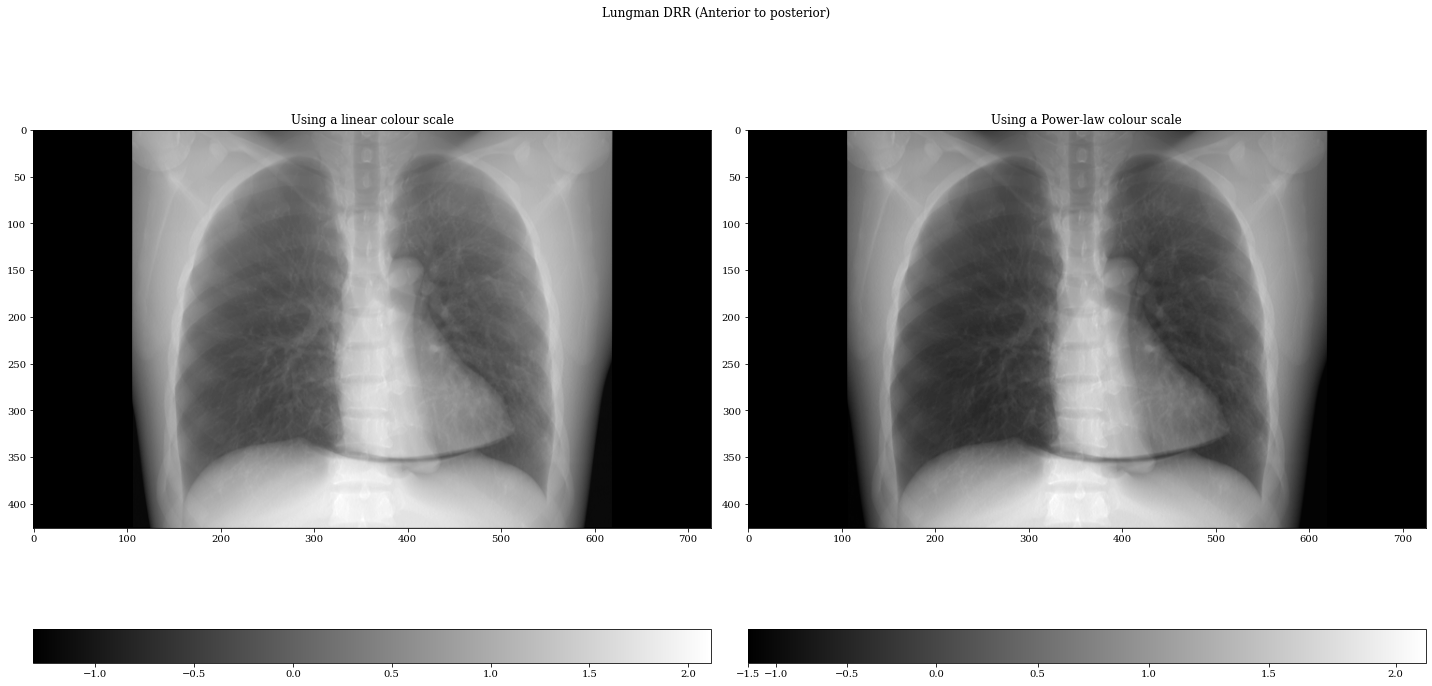

In [51]:

print("Optimum c for right to left", f"{res_rl.X[0][0]:.2f}", ",", f"{ res_rl.X[0][1]:.2f}")
print("Optimum c for anterior to posterior", f"{res_ap.X[0][0]:.2f}", ",", f"{ res_ap.X[0][1]:.2f}")

runtimes_drr_rl = []
runtimes_drr_ap = []

for i in range(50):
    start_time = datetime.datetime.now()

    DRR_RL = doLungmanDRRNumpy(1, 0, 0, 
                              res_rl.X[0][0], res_rl.X[0][1], 
                                "DRR_RL" 
                               );

    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes_drr_rl.append(delta_time.total_seconds() * 1000)

    start_time = datetime.datetime.now()

    DRR_AP = doLungmanDRRNumpy(0, -1, 0,
                                 res_ap.X[0][0], res_ap.X[0][1], 
                                    "DRR_AP" 
                                   );

    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes_drr_ap.append(delta_time.total_seconds() * 1000)

normImage(DRR_RL)
normImage(DRR_AP)
displayLinearPowerScales(DRR_RL,  "Lungman DRR (Right to left)", "plots/R_L_lungman_radiograph");
displayLinearPowerScales(DRR_AP,  "Lungman DRR (Anterior to posterior)", "plots/A_P_lungman_radiograph");

In [52]:
if (len(runtimes_drr_rl) > 0):
    runtimes_drr_rl_avg = round(np.mean(runtimes_drr_rl))
    runtimes_drr_rl_std = round(np.std(runtimes_drr_rl))
else:
    runtimes_drr_rl_avg = -1;
    runtimes_drr_rl_std = 0;

In [53]:
if (len(runtimes_drr_ap) > 0):
    runtimes_drr_ap_avg = round(np.mean(runtimes_drr_ap))
    runtimes_drr_ap_std = round(np.std(runtimes_drr_ap))
else:
    runtimes_drr_ap_avg = -1;
    runtimes_drr_ap_std = 0;

## CT reconstruction of the simulated sinogram

In [54]:
fname = "gVirtualXRay_output_data/simulated_CT_volume_in_mu.mha"

if True: #not os.path.exists(fname):

    # Scikit-Image
    if tomography_backend == "scikit-image":
        
        filter_name = "ramp" # Default
        filter_name = "shepp-logan"
        filter_name = "cosine"
        filter_name = "hamming"
        filter_name = "hann"     
        
        simulated_CT_volume_in_mu = recons(sinograms,
                                  theta_deg,  
                                  "parallel",
                                  filter_name,
                                  real_CT_in_HU.shape[2],
                                  real_CT_in_HU.shape[1],
                                  real_CT_in_HU.shape[0],
                                  tomography_backend)
    
    # Tomopy or Tigre
    else:
        
        # For TIGRE
        # filter_name = "ram_lak"
        filter_name = "shepp_logan"
        # filter_name = "cosine"
        # filter_name = "hamming"
        # filter_name = "hann"     
        
        
        # For Tomopy
        # filter_name = "shepp"
        # filter_name = "cosine"
        filter_name = "hann"
        # filter_name = "hamming"
        # filter_name = "ramlak"
        # filter_name = "parzen"
        # filter_name = "butterworth"
        
        simulated_CT_volume_in_mu = recons(minus_log_projs,
                                  theta_deg,  
                                  "parallel", 
                                  filter_name,
                                  real_CT_in_HU.shape[2],
                                  real_CT_in_HU.shape[1],
                                  real_CT_in_HU.shape[0],
                                  tomography_backend) 
        
    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(simulated_CT_volume_in_mu)
        sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

        sitk_image.SetOrigin((-pixel_width * real_CT_in_HU.shape[2] / 2.0,
                              -pixel_width * real_CT_in_HU.shape[1] / 2.0,
                              -pixel_height * real_CT_in_HU.shape[0] / 2.0))

        sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    sitk_image = sitk.ReadImage(fname)
    simulated_CT_volume_in_mu = sitk.GetArrayFromImage(sitk_image)

# del sinograms # Not needed anymore

# Transform to Hounsfield units

In [55]:
fname = "gVirtualXRay_output_data/simulated_CT_volume_in_HU.mha"

# The file does not exist
if True: # not os.path.exists(fname):

    simulated_CT_volume_in_HU = mu2HU(simulated_CT_volume_in_mu)

    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(simulated_CT_volume_in_HU)
        sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

        sitk_image.SetOrigin((-pixel_width * simulated_CT_volume_in_HU.shape[2] / 2.0,
                              -pixel_width * simulated_CT_volume_in_HU.shape[1] / 2.0,
                              -pixel_height * simulated_CT_volume_in_HU.shape[0] / 2.0))

        sitk.WriteImage(sitk_image, fname, useCompression=True)

# The file already exist
else:
    sitk_image = sitk.ReadImage(fname)
    simulated_CT_volume_in_HU = sitk.GetArrayFromImage(sitk_image)

# del CT_volume_in_mu # Not needed anymore

## Comparison the analytic simulation with the ground truth data

### Quantitative validation

Compute image metrics between the two simulated images:

1. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
2. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of ZNCC is 100%, and SSIM 1.

Note than the [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), is not used due to 1) zero values in the ground truth, and 2)  values are very smalls. Using the MAPE would lead to large errors for these reasons.

In [56]:
def compare(ref_image, test_image):

    ZNCC = np.mean((ref_image - ref_image.mean()) / ref_image.std() * (test_image - test_image.mean()) / test_image.std())
    print("ZNCC:", "{0:0.2f}".format(100 * ZNCC) + "%")

    offset1 = min(ref_image.min(), test_image.min())
    offset2 = 0.1 * (ref_image.max() - ref_image.min())
    MAPE = mape(ref_image.flatten() - offset1 + offset2, test_image.flatten() - offset1 + offset2)
    print("MAPE:", "{0:0.2f}".format(100 * MAPE) + "%")

    SSIM = ssim(ref_image, test_image, data_range=ref_image.max() - ref_image.min())
    print("SSIM:", "{0:0.2f}".format(SSIM))
    
    return ZNCC, MAPE, SSIM

In [57]:
real_CT_in_HU = real_CT_in_HU[1:real_CT_in_HU.shape[0] - 1]
digital_phatom_in_HU = digital_phatom_in_HU[1:digital_phatom_in_HU.shape[0] - 1]
digital_phantom_CT_reconst_in_HU = digital_phantom_CT_reconst_in_HU[1:digital_phantom_CT_reconst_in_HU.shape[0] - 1]
simulated_CT_volume_in_HU = simulated_CT_volume_in_HU[1:simulated_CT_volume_in_HU.shape[0] - 1]

real_CT_in_mu = real_CT_in_mu[1:real_CT_in_mu.shape[0] - 1]
digital_phatom_in_mu = digital_phatom_in_mu[1:digital_phatom_in_mu.shape[0] - 1]
digital_phantom_CT_reconst_in_mu = digital_phantom_CT_reconst_in_mu[1:digital_phantom_CT_reconst_in_mu.shape[0] - 1]
simulated_CT_volume_in_mu = simulated_CT_volume_in_mu[1:simulated_CT_volume_in_mu.shape[0] - 1]

## real CT vs digital phantom HU

In [58]:
compare(real_CT_in_HU, digital_phatom_in_HU);

ZNCC: 97.94%
MAPE: 7.79%
SSIM: 0.86


ZNCC: 97.76%
MAPE: 10.07%
SSIM: 0.80


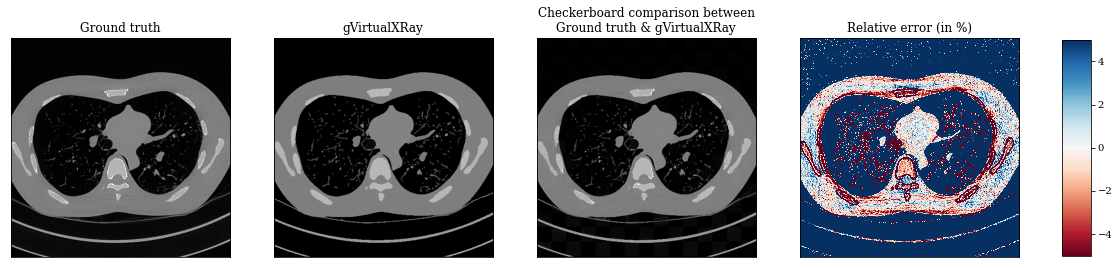

In [72]:
ref_slice = real_CT_in_HU[real_CT_in_HU.shape[0] // 2]
test_slice = digital_phatom_in_HU[digital_phatom_in_HU.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "Digital phantom",
                  "plots/lungman-compare-real_CT_in_HU-digital_phatom_in_HU",
                  False,
                  -1000, 1000)

compare(ref_slice, test_slice);

## real CT vs recons of digital phantom HU

In [60]:
compare(real_CT_in_HU, digital_phantom_CT_reconst_in_HU);

ZNCC: 96.37%
MAPE: 11.18%
SSIM: 0.56


ZNCC: 95.92%
MAPE: 15.45%
SSIM: 0.52


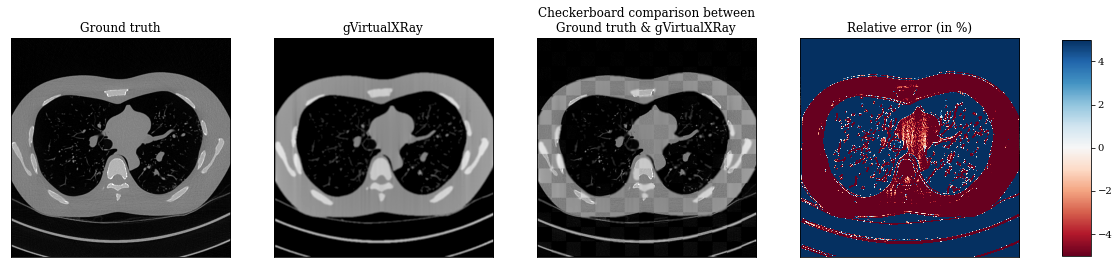

In [61]:
ref_slice = real_CT_in_HU[real_CT_in_HU.shape[0] // 2]
test_slice = digital_phantom_CT_reconst_in_HU[digital_phantom_CT_reconst_in_HU.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "Reconstructed from\nDigital phantom projections",
                  "plots/lungman-compare-real_CT_in_HU-digital_phantom_CT_reconst_in_HU",
                  False,
                  -1000, 1000)

compare(ref_slice, test_slice);

## Real CT vs recons of simu projs HU

In [62]:
ZNCC_CT, MAPE_CT, SSIM_CT = compare(real_CT_in_HU, simulated_CT_volume_in_HU);

ZNCC: 96.70%
MAPE: 12.11%
SSIM: 0.57


ZNCC: 96.31%
MAPE: 15.82%
SSIM: 0.53


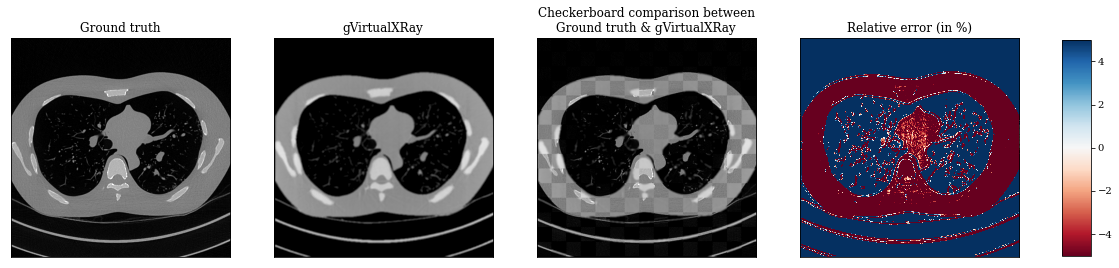

In [63]:
ref_slice = real_CT_in_HU[real_CT_in_HU.shape[0] // 2]
test_slice = simulated_CT_volume_in_HU[simulated_CT_volume_in_HU.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/lungman-compare-real_CT_in_HU-simulated_CT_volume_in_HU",
                  False,
                  -1000, 1000)

compare(ref_slice, test_slice);

## digital phantom  vs recons of simu projs HU

In [64]:
compare(digital_phatom_in_HU, simulated_CT_volume_in_HU);

ZNCC: 96.67%
MAPE: 14.20%
SSIM: 0.46


ZNCC: 96.13%
MAPE: 17.60%
SSIM: 0.45


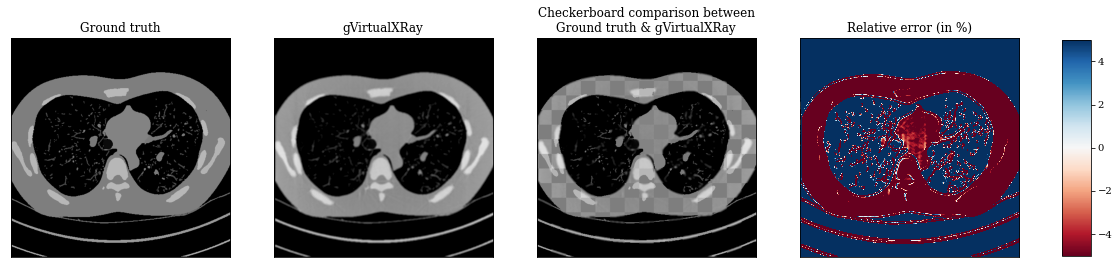

In [65]:
ref_slice = digital_phatom_in_HU[digital_phatom_in_HU.shape[0] // 2]
test_slice = simulated_CT_volume_in_HU[simulated_CT_volume_in_HU.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/lungman-compare-digital_phatom_in_HU-simulated_CT_volume_in_HU",
                  False,
                  -1000, 1000)

compare(ref_slice, test_slice);

## recons of digital phantom vs recons of simu projs HU

In [66]:
ZNCC_phantom, MAPE_phantom, SSIM_phantom = compare(digital_phantom_CT_reconst_in_HU, simulated_CT_volume_in_HU);

ZNCC: 99.34%
MAPE: 4.20%
SSIM: 0.84


ZNCC: 99.25%
MAPE: 6.24%
SSIM: 0.77


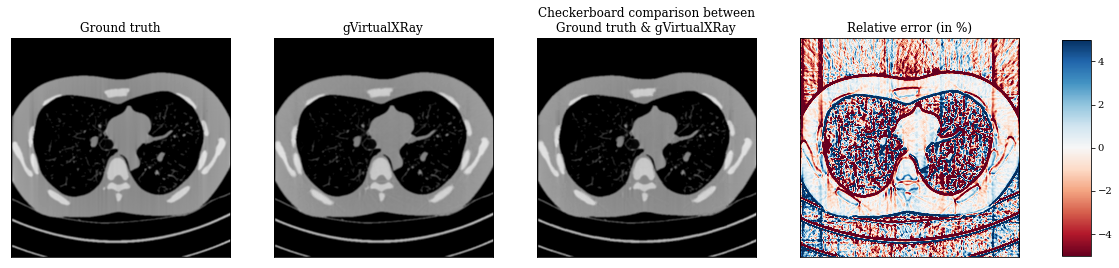

In [67]:
ref_slice = digital_phantom_CT_reconst_in_HU[digital_phantom_CT_reconst_in_HU.shape[0] // 2]
test_slice = simulated_CT_volume_in_HU[simulated_CT_volume_in_HU.shape[0] // 2]

fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/lungman-compare-digital_phantom_CT_reconst_in_HU-simulated_CT_volume_in_HU",
                  False,
                  -1000, 1000)

compare(ref_slice, test_slice);

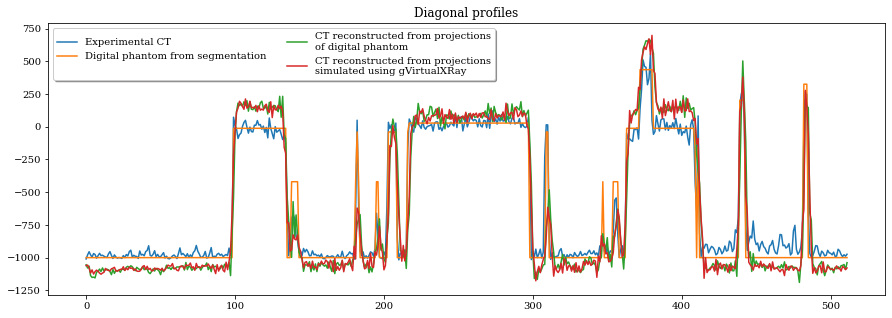

In [68]:
real_CT_diag = np.diag(real_CT_in_HU[real_CT_in_HU.shape[0] // 2])
digital_phatom_diag = np.diag(digital_phatom_in_HU[digital_phatom_in_HU.shape[0] // 2])
digital_phantom_CT_reconst_diag = np.diag(digital_phantom_CT_reconst_in_HU[digital_phantom_CT_reconst_in_HU.shape[0] // 2])
lungman_simu_CT_recons_diag = np.diag(simulated_CT_volume_in_HU[simulated_CT_volume_in_HU.shape[0] // 2])

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(real_CT_diag, label="Experimental CT")
ax.plot(digital_phatom_diag, label="Digital phantom from segmentation")
ax.plot(digital_phantom_CT_reconst_diag, label="CT reconstructed from projections\nof digital phantom")
ax.plot(lungman_simu_CT_recons_diag, label="CT reconstructed from projections\nsimulated using gVirtualXRay")

ax.legend(loc='best',
          ncol=2, fancybox=True, shadow=True)

# plt.legend()

plt.savefig('plots/lungman-profiles-CT-HU.pdf')
plt.savefig('plots/lungman-profiles-CT-HU.png')

## Projections

In [76]:
ZNCC_projs, MAPE_projs, SSIM_projs = compare(digital_phantom_proj, minus_log_projs)

ZNCC: 99.88%
MAPE: 1.19%
SSIM: 0.99


ZNCC: 99.91%
MAPE: 0.92%
SSIM: 1.00


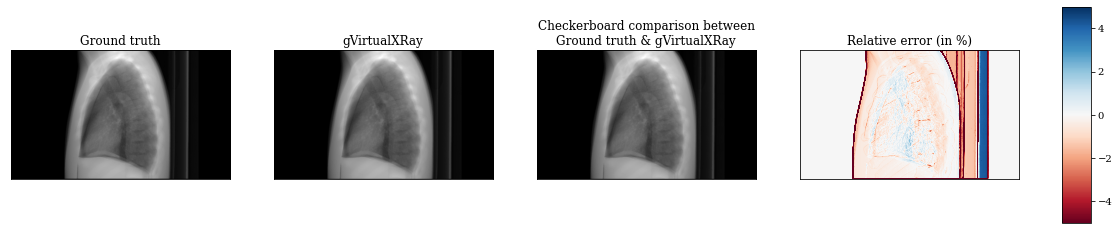

In [70]:
ref_slice = digital_phantom_proj[digital_phantom_proj.shape[0] // 2]
test_slice = minus_log_projs[minus_log_projs.shape[0] // 2]

ref_slice = skimage.transform.rotate(ref_slice, 180)
test_slice = skimage.transform.rotate(test_slice, 180)

fullCompareImages(ref_slice,
                  test_slice,
                  "gVirtualXRay",
                  "plots/lungman-compare-projs",
                  False,
                  ref_slice.min(), ref_slice.max(),
                 True)

compare(ref_slice, test_slice);

**Medical orientations with plastimatch.**

R-L:
ZNCC: 99.83%
MAPE: 1.92%
SSIM: 0.98

A-P:
ZNCC: 99.51%
MAPE: 1.96%
SSIM: 0.94


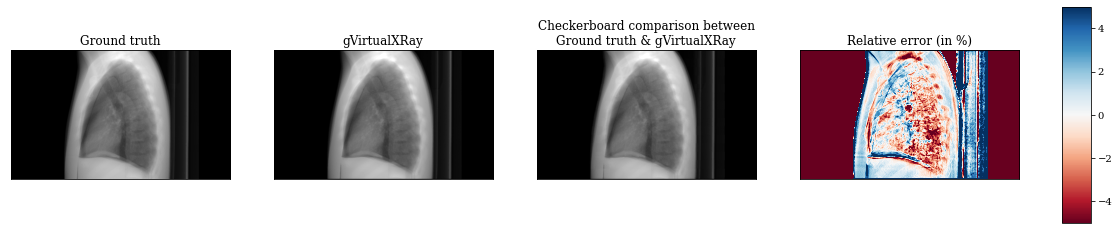

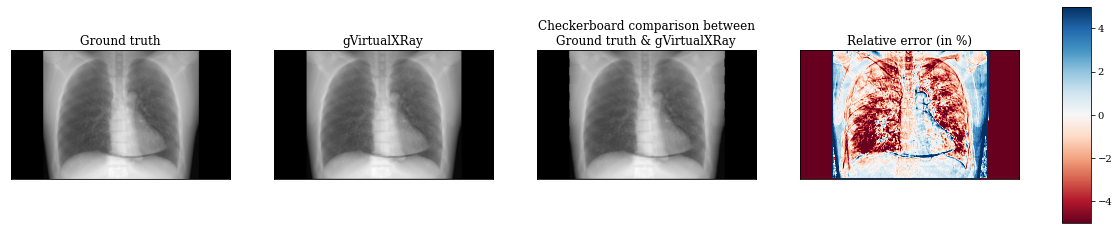

In [89]:
print('R-L:')
ref_proj = DRR_RL
test_proj = minus_log_proj_rl
ZNCC_DRR_RL, MAPE_DRR_RL, SSIM_DRR_RL = compare(ref_proj, test_proj)
fullCompareImages(ref_proj,
                  test_proj,
                  "gVirtualXRay",
                  "plots/lungman-compare-projs-plastimatch-rl",
                  False,
                  ref_proj.min(), ref_proj.max())
print('\nA-P:')

ref_proj = DRR_AP
test_proj = minus_log_proj_ap
ZNCC_DRR_AP, MAPE_DRR_AP, SSIM_DRR_AP = compare(ref_proj, test_proj)
fullCompareImages(ref_proj,
                  test_proj,
                  "gVirtualXRay",
                  "plots/lungman-compare-projs-plastimatch-ap",
                  False,
                  ref_proj.min(), ref_proj.max())

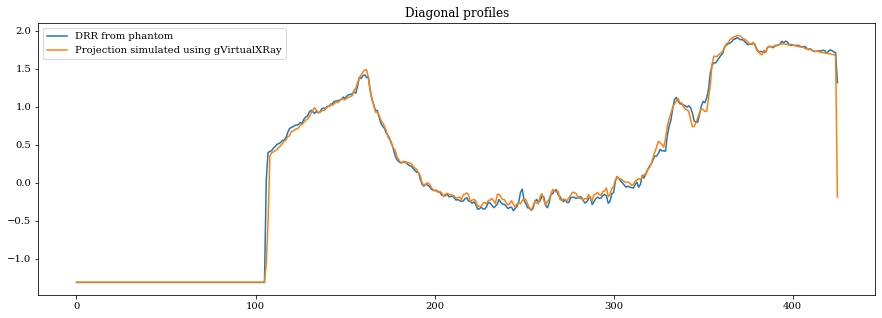

In [74]:
ref_diag = np.diag(ref_proj)
test_diag = np.diag(test_proj)

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(ref_diag, label="DRR from phantom")
ax.plot(test_diag, label="Projection simulated using gVirtualXRay")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.legend()

Print a row of the table for the paper

In [82]:
print("Lungman CT acquisition & Projection of synthetic volume & " + 
      "{0:0.2f}".format(100 * MAPE_projs) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_projs) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_projs) + "    &    $" +
      str(digital_phantom_proj.shape[2]) + " \\times " + str(digital_phantom_proj.shape[1]) + " \\times " + str(digital_phantom_proj.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    N/A    & " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

Lungman CT acquisition & Projection of synthetic volume & 1.19\%    &    99.88\%    &    0.99    &    $725 \times 426 \times 1000$    &    19277756    &    N/A    & $27 \pm 7$ \\


In [83]:
print("Lungman CT reconstruction & Reconstruction of synthetic volume & " + 
      "{0:0.2f}".format(100 * MAPE_phantom) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_phantom) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_phantom) + "    &    $" +
      str(digital_phantom_CT_reconst_in_mu.shape[2]) + " \\times " + str(digital_phantom_CT_reconst_in_mu.shape[1]) + " \\times " + str(digital_phantom_CT_reconst_in_mu.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    N/A    & " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

Lungman CT reconstruction & Reconstruction of synthetic volume & 4.20\%    &    99.34\%    &    0.84    &    $512 \times 512 \times 424$    &    19277756    &    N/A    & $27 \pm 7$ \\


In [84]:
print("Lungman CT reconstruction & Real CT & " + 
      "{0:0.2f}".format(100 * MAPE_CT) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_CT) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_CT) + "    &    $" +
      str(digital_phantom_CT_reconst_in_mu.shape[2]) + " \\times " + str(digital_phantom_CT_reconst_in_mu.shape[1]) + " \\times " + str(digital_phantom_CT_reconst_in_mu.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    N/A    & " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

Lungman CT reconstruction & Real CT & 12.11\%    &    96.70\%    &    0.57    &    $512 \times 512 \times 424$    &    19277756    &    N/A    & $27 \pm 7$ \\


In [93]:
print("Lungman AP view & Plastimatch DRR & " + 
      "{0:0.2f}".format(100 * MAPE_DRR_AP) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_DRR_AP) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_DRR_AP) + "    &    $" +
      str(DRR_AP.shape[1]) + " \\times " + str(DRR_AP.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " + str(runtimes_drr_ap_avg) + " \\pm " + str(runtimes_drr_ap_std) + "    & " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

Lungman AP view & Plastimatch DRR & 1.96\%    &    99.51\%    &    0.94    &    $725 \times 426$    &    19277756    &    421 \pm 9    & $27 \pm 7$ \\


In [94]:
print("Lungman RL view & Plastimatch DRR & " + 
      "{0:0.2f}".format(100 * MAPE_DRR_RL) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_DRR_RL) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_DRR_RL) + "    &    $" +
      str(DRR_AP.shape[1]) + " \\times " + str(DRR_AP.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " + str(runtimes_drr_rl_avg) + " \\pm " + str(runtimes_drr_rl_std) + "    & " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

Lungman RL view & Plastimatch DRR & 1.92\%    &    99.83\%    &    0.98    &    $725 \times 426$    &    19277756    &    422 \pm 7    & $27 \pm 7$ \\


In [ ]:
ncols = 3
nrows = 2

ref_volume = real_CT_in_HU # digital_phantom_CT_reconst_in_mu
test_volume = simulated_CT_volume_in_HU


step = int(ref_volume.shape[0] / (ncols * nrows))
slices = range(0, int(ref_volume.shape[0]), step)

fig = plt.figure(figsize= (10,10))


for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1 + 1) + "/" + str(ref_volume.shape[0] + 2))
        
        # ref_slice = ground_truth_CT_recons_in_HU[ground_truth_CT_recons_in_HU.shape[0] // 2]
        # test_slice = CT_volume_in_HU[CT_volume_in_HU.shape[0] // 2]

        ref_slice = ref_volume[slice_id]
        test_slice = test_volume[slice_id]

        comp_equalized = compare_images(ref_slice, test_slice, method='checkerboard', n_tiles=(15,15))

        ax.imshow(comp_equalized, cmap='gray', vmin=-1000, vmax=1000)
        
plt.tight_layout()

plt.savefig('plots/lungman-compare-real-simulated-CT-HU.pdf')
plt.savefig('plots/lungman-compare-real-simulated-CT-HU.png')

In [ ]:
ncols = 3
nrows = 2

ref_volume = digital_phantom_CT_reconst_in_HU
test_volume = simulated_CT_volume_in_HU


step = int(ref_volume.shape[0] / (ncols * nrows))
slices = range(0, int(ref_volume.shape[0]), step)

fig = plt.figure(figsize= (10,10))


for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1 + 1) + "/" + str(ref_volume.shape[0] + 2))
        
        # ref_slice = ground_truth_CT_recons_in_HU[ground_truth_CT_recons_in_HU.shape[0] // 2]
        # test_slice = CT_volume_in_HU[CT_volume_in_HU.shape[0] // 2]

        ref_slice = ref_volume[slice_id]
        test_slice = test_volume[slice_id]

        comp_equalized = compare_images(ref_slice, test_slice, method='checkerboard', n_tiles=(15,15))

        ax.imshow(comp_equalized, cmap='gray', vmin=-1000, vmax=1000)
        
plt.tight_layout()

plt.savefig('plots/lungman-compare-phantom-simulated-CT-HU.pdf')
plt.savefig('plots/lungman-compare-phantom-simulated-CT-HU.png')

## Check Hounsfield Units for all the structures

In [ ]:
# Read the map for isovalue/label to average HU
sitk_meta_reader = sitk.ImageFileReader();
sitk_meta_reader.SetImageIO("MetaImageIO");
mapHandle = open("./lungman_data/segmentation-uncompressed/map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

# Read the labbeled volume
label_rel_path = "./lungman_data/segmentation-uncompressed/labels.mha" ;#+ tuple_parts[2];
sitk_meta_reader.SetFileName(label_rel_path);
labels = sitk_meta_reader.Execute();

# Create the binary erosion filter
erode = sitk.BinaryErodeImageFilter();

offset1 = min(real_CT_in_HU.min(), simulated_CT_volume_in_HU.min())
offset2 = 0.01 * (real_CT_in_HU.max() - real_CT_in_HU.min())
ground_truth_CT_recons_in_HU_corrected = real_CT_in_HU - offset1 + offset2
CT_volume_in_HU_corrected = simulated_CT_volume_in_HU - offset1 + offset2


acc_avg_rel_diff = 0;
vec_avg_rel_diff = [];
i = 0;
cols=["Name","Mean reference HU","Stddev reference HU", "Mean simulated HU", "Stddev simulated HU", "Relative Error (in %)", "Absolute Error"]
data = []
print("Name\t\tReference HU\tSimulated HU\tRelative Error (in %)\tAbsolute Error");
while ( i < len(split_lines)):
    row = []
    tuple_parts = split_lines[i].split('\t');
    
    name = tuple_parts[2][0:-4];
    kernel_radius = 2;
    
    # Sheets are too slim to be eroded so much
    if (name.find("sheet") != -1):
        kernel_radius = 1;
    
    # Erode the mask
    erode.SetKernelRadius(kernel_radius);
    erode.SetForegroundValue(int(tuple_parts[0]));
    sitk_mask = erode.Execute(labels);
        
    mask = np.array(sitk.GetArrayFromImage(sitk_mask));
    sitk_mask = None
   
    # Drop the first and last slices
    mask = mask[1:mask.shape[0] - 1]

    # Apply mask to simulated CT
    simulated_masked = simulated_CT_volume_in_HU[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
    ground_masked = real_CT_in_HU[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
    
    # abs_diff = np.mean(np.abs(simulated_masked - ground_masked))
    # avg_rel_diff = np.mean(np.abs((simulated_masked - ground_masked) / ground_masked)) * 100
    
    avg_simulated_HU = np.mean(simulated_masked);
    stddev_simulated_HU = np.std(simulated_masked);
    # avg_ground_HU = float(tuple_parts[1]);
    avg_ground_HU = np.mean(ground_masked);
    stddev_ground_HU = np.std(ground_masked);
    
    avg_rel_diff = (avg_ground_HU - avg_simulated_HU) / avg_ground_HU;
    avg_rel_diff *= 100.0;
    abs_diff =  abs(avg_simulated_HU - avg_ground_HU);

#     ground_corrected_masked = ground_truth_CT_recons_in_HU_corrected[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
#     simulated_corrected_masked = CT_volume_in_HU_corrected[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)

#     diff = ground_corrected_masked - simulated_corrected_masked
#     abs_diff = np.mean(np.abs(diff))
#     avg_rel_diff = 100 * np.mean(np.abs(diff / ground_corrected_masked))


    format = "{structure:<15}\t{ref:<15.3f}\t{sim:<15.3f}\t{rel:<15.3f}\t\t{abs:.3f}";
    print(format.format(structure=name, ref=avg_ground_HU, sim=avg_simulated_HU, rel=avg_rel_diff, abs=abs_diff));
    row.append(name)
    row.append(avg_ground_HU)
    row.append(stddev_ground_HU)
    row.append(avg_simulated_HU)
    row.append(stddev_simulated_HU)
    row.append(avg_rel_diff)
    row.append(abs_diff)
    
    data.append(row)
    
    acc_avg_rel_diff += abs(avg_rel_diff);
    vec_avg_rel_diff.append(acc_avg_rel_diff);
    i+=1;
    
avg_rel_diff = acc_avg_rel_diff / len(vec_avg_rel_diff);
print('\n')
format = "Average relative error = {error:.3f}%";
print(format.format(error=avg_rel_diff));

In [ ]:
df_HU = pd.DataFrame(data=data, columns=cols)
df_HU.to_csv("gVirtualXRay_output_data/lungman-HU.csv")